In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from code_ import thinkbayes, thinkstats

In the 2010-11 National Hockey League (NHL) Finals, my beloved Boston Bruins played
a best-of-seven championship series against the despised Vancouver Canucks. Boston
lost the first two games 0-1 and 2-3, then won the next two games 8-1 and 4-0. At this
point in the series, what is the probability that Boston will win the next game, and what
is their probability of winning the championship?
As always, to answer a question like this, we need to make some assumptions. First, it
is reasonable to believe that goal scoring in hockey is at least approximately a Poisson
process, which means that it is equally likely for a goal to be scored at any time during
a game. Second, we can assume that against a particular opponent, each team has some
long-term average goals per game, denoted λ.

Given these assumptions, my strategy for answering this question is:

1. Use statistics from previous games to choose a prior distribution for λ.
2. Use the score from the first four games to estimate λ for each team.
3. Use the posterior distributions of λ to compute distribution of goals for each team,
the distribution of the goal differential, and the probability that each team wins the
next game.
4. Compute the probability that each team wins the series.

In [2]:
pd.options.display.max_columns = None
df = pd.read_csv('code_/hockey_data.csv')
df.head()

,Season,Game,Team,Pd1,Pd2,Pd3,OT,SO Win,Total
0,2009,20001,NYR,0,1,1,0,0,2
1,2009,20001,TBL,0,0,1,0,0,1
2,2009,20002,OTT,1,2,0,0,0,3
3,2009,20002,PIT,1,1,1,1,0,4
4,2009,20003,NYR,0,2,0,0,0,2


In [3]:
df['Team'].unique()

array(['NYR', 'TBL', 'OTT', 'PIT', 'DET', 'TOR', 'BOS', 'COL', 'CGY',
       'VAN', 'ANA', 'SJS', 'NJD', 'NYI', 'CHI', 'CAR', 'FLA', 'BUF',
       'MTL', 'ATL', 'WSH', 'NSH', 'STL', 'CBJ', 'DAL', 'PHI', 'MIN',
       'PHX', 'LAK', 'EDM', 'WPG'], dtype=object)

In [4]:
df[df['Season']==2011].describe()

,Season,Game,Pd1,Pd2,Pd3,OT,SO Win,Total
count,2460.0,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000
mean,2011.0,20615.500000,0.810163,0.934959,0.921951,0.060163,0.060569,2.787805
std,0.0,355.142489,0.898769,0.941042,0.939187,0.237836,0.238587,1.660394
min,2011.0,20001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2011.0,20308.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,2011.0,20615.500000,1.000000,1.000000,1.000000,0.000000,0.000000,3.000000
75%,2011.0,20923.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000
max,2011.0,21230.000000,5.000000,6.000000,5.000000,1.000000,1.000000,10.000000


<AxesSubplot:ylabel='Frequency'>

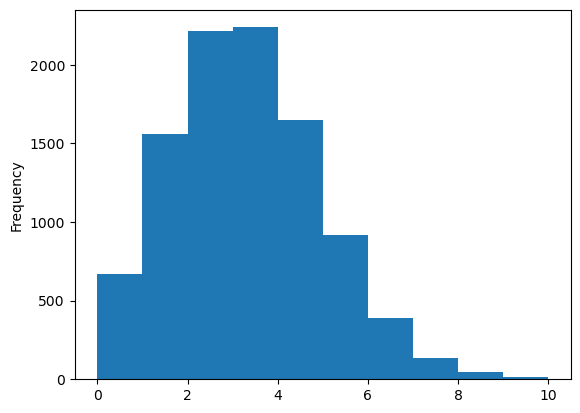

In [5]:
df['Total'].plot(kind='hist', bins=10)

In [6]:
(
    df[
        (df['Team'].isin(['BOS', 'VAN']))
        &(df['Season']==2011)
    ]
    .groupby('Team')
    .agg(
        avg_total=('Total', 'mean'),
        std_total=('Total', 'std')
    )
)

,avg_total,std_total
Team,,
BOS,3.000000,1.872478
VAN,3.195122,1.745817


In [7]:
df_pair = (
    df[df['Season']==2011]
    # df
    .groupby('Game')
    .agg(
        pair=('Team', lambda x: 'v'.join(sorted(x))),
        sum_total=('Total', 'sum')
    )
    .groupby('pair')
    .agg(
        n=('pair', len),
        mean_total=('sum_total', 'mean'),
        std_total=('sum_total', 'std')
    )
    .reset_index()
)
df_pair = df_pair[df_pair['n']>=3]
df_pair.head()

,pair,n,mean_total,std_total
4,ANAvCBJ,4,5.500000,1.290994
5,ANAvCGY,4,7.250000,2.061553
6,ANAvCHI,4,4.000000,1.154701
7,ANAvCOL,4,6.250000,2.753785
8,ANAvDAL,6,6.166667,1.602082


In [8]:
[x for x in df_pair['pair'].unique() if 'VAN' in x]

['ANAvVAN',
 'CBJvVAN',
 'CGYvVAN',
 'CHIvVAN',
 'COLvVAN',
 'DALvVAN',
 'DETvVAN',
 'EDMvVAN',
 'LAKvVAN',
 'MINvVAN',
 'NSHvVAN',
 'PHXvVAN',
 'SJSvVAN',
 'STLvVAN']

In [44]:
class Hockey(thinkbayes.Suite):
    """Represents hypotheses about the scoring rate for a team."""

    def __init__(self, USE_SUMMARY_DATA=True, name=''):
        """Initializes the Hockey object.

        name: string
        """
        if USE_SUMMARY_DATA:
            # HE ORIGINALLY CALCULATED THIS DIFFERENTLY
            # AND THAT APPROACH WAS MUCH CLOSER TO THE ODDS AT THAT TIME

            # prior based on each team's average goals scored
            mu = (3.0 + 3.195122)/2
            # sigma is std of means not goals which makes sense
            # bc you try to estimate variaton in goal average not goals itself
            sigma = 0.265#(1.872478 + 1.745817)/2
        else:
            # prior based on each pair-wise match-up
            mu = 2.8
            sigma = 0.85

        pmf = thinkbayes.MakeGaussianPmf(mu, sigma, 4, low=0)
        thinkbayes.Suite.__init__(self, pmf, name=name)
            
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        Evaluates the Poisson PMF for lambda and k.

        hypo: goal scoring rate in goals per game
        data: goals scored in one period
        """
        lam = hypo
        k = data
        like = thinkbayes.EvalPoissonPmf(k, lam)
        return like
def MakeGoalPmf(suite, high=10):
    """Makes the distribution of goals scored, given distribution of lam.

    suite: distribution of goal-scoring rate
    high: upper bound

    returns: Pmf of goals per game
    """
    metapmf = thinkbayes.Pmf()

    for lam, prob in suite.Items():
        pmf = thinkbayes.MakePoissonPmf(lam, high)
        metapmf.Set(pmf, prob)

    mix = thinkbayes.MakeMixture(metapmf, name=suite.name)
    return mix


def MakeGoalTimePmf(suite):
    """Makes the distribution of time until first goal.

    suite: distribution of goal-scoring rate

    returns: Pmf of goals per game
    """
    metapmf = thinkbayes.Pmf()

    for lam, prob in suite.Items():
        if lam == 0:
            continue
        # high is eq to 2 bc its unlikely going two games without scoring a goal
        pmf = thinkbayes.MakeExponentialPmf(lam, high=2, n=2001)
        metapmf.Set(pmf, prob)

    mix = thinkbayes.MakeMixture(metapmf, name=suite.name)
    return mix

In [45]:
bos = Hockey(name='bruins', USE_SUMMARY_DATA=True)
bos.UpdateSet([0, 2, 8, 4]) # goals in first for games
van = Hockey(name='canucks', USE_SUMMARY_DATA=True)
van.UpdateSet([1, 3, 1, 0]) 

0.00023485959894500722

In [46]:
bos_mix_pmf = MakeGoalPmf(bos)
van_mix_pmf = MakeGoalPmf(van)

In [47]:
def plot_multiple(*args):
    for function in args:
        x, y = [], []
        for k, v in function.GetDict().items():
            x.append(k)
            y.append(v)
        plt.plot(x, y, label=function.name)
    plt.legend()
    plt.grid()
    plt.show()

    return

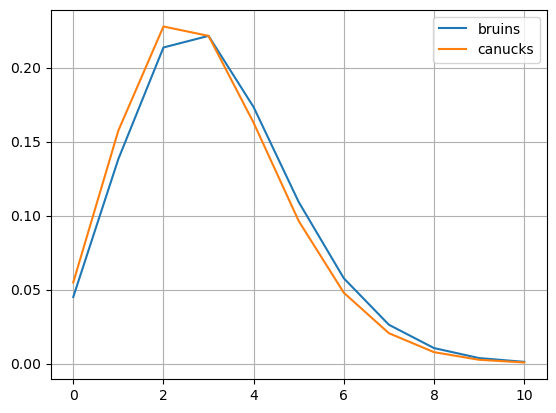

In [48]:
plot_multiple(bos_mix_pmf, van_mix_pmf)

In [49]:
diff_goals = bos_mix_pmf - van_mix_pmf
p_win = diff_goals.ProbGreater(0)
p_loss = diff_goals.ProbLess(0)
p_tie = diff_goals.Prob(0)

print(f'Prob of BOS win: {p_win}\nProb of BOS loss: {p_loss}\nProb of draw: {p_tie}')

Prob of BOS win: 0.44870763781406753
Prob of BOS loss: 0.38736020293932305
Prob of draw: 0.16393215924660862


If regular time ends with draw "sudden death" over time is played. In this regime who scores first wins so time until first goal is important. 

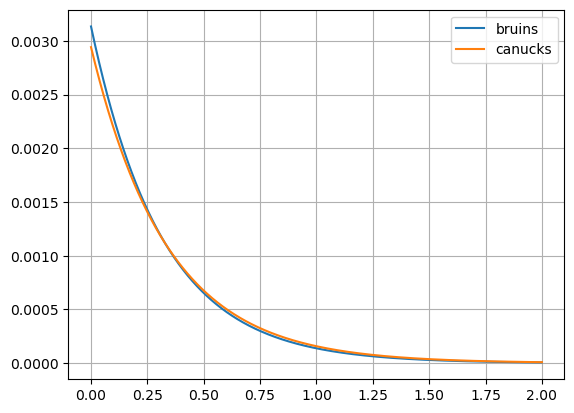

In [50]:
bos_time_dist = MakeGoalTimePmf(bos)
van_time_dist = MakeGoalTimePmf(van)
# X axis is games until goal
plot_multiple(bos_time_dist, van_time_dist)

In [51]:
# probability that pm1 is less than pmf2
p_overtime = thinkbayes.PmfProbLess(bos_time_dist, van_time_dist)
p_overtime

0.5150178229107012

In [52]:
# probability of win including overtime
diff_goals.ProbGreater(0) + p_tie * p_overtime

0.5331356215743063

In [53]:
# WINNING THE SERIES
# win the next two
p_series = p_win**2
# split the next two, win the third
p_series += 2 * p_win * (1-p_win) * p_win
p_series

0.42333134753090285

In [59]:
goal_dist = bos_mix_pmf + van_mix_pmf

In [68]:
1/goal_dist.ProbGreater(3)

1.1737761783837881

As always, the analysis in this chapter is based on modeling decisions, and modeling is
almost always an iterative process. In general, you want to start with something simple
that yields an approximate answer, identify likely sources of error, and look for oppor‐
tunities for improvement.
In this example, I would consider these options:
• I chose a prior based on the average goals per game for each team. But this statistic
is averaged across all opponents. Against a particular opponent, we might expect
more variability. For example, if the team with the best offense plays the team with
the worst defense, the expected goals per game might be several standard deviations
above the mean.
• For data I used only the first four games of the championship series. If the same
teams played each other during the regular season, I could use the results from
those games as well. One complication is that the composition of teams changes
during the season due to trades and injuries. So it might be best to give more weight
to recent games.
• To take advantage of all available information, we could use results from all regular
season games to estimate each team’s goal scoring rate, possibly adjusted by esti‐
mating an additional factor for each pairwise match-up. This approach would be
more complicated, but it is still feasible.
For the first option, we could use the results from the regular season to estimate the
variability across all pairwise match-ups. Thanks to Dirk Hoag at http://forechecker.blog
spot.com/, I was able to get the number of goals scored during regulation play (not
overtime) for each game in the regular season.
Teams in different conferences only play each other one or two times in the regular
season, so I focused on pairs that played each other 4–6 times. For each pair, I computed
the average goals per game, which is an estimate of λ, then plotted the distribution of
these estimates.
The mean of these estimates is 2.8, again, but the standard deviation is 0.85, substantially
higher than what we got computing one estimate for each team.
If we run the analysis again with the higher-variance prior, the probability that the
Bruins win the series is 80%, substantially higher than the result with the low-variance
prior, 57%.
So it turns out that the results are sensitive to the prior, which makes sense considering
how little data we have to work with. Based on the difference between the low-variance
model and the high-variable model, it seems worthwhile to put some effort into getting
the prior right.